In [1]:
# Carga inicial de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
def get_X_y(datos, dias):
    
    X, y = [], []
    
    for i in range(len(datos) - dias):
        X.append(datos[i:(i + dias), :])
        y.append(datos[i + dias, 0])
        
    return np.array(X), np.array(y)

def visualizar_pred_test(y_test, y_pred, fechas, tit):
    plt.figure(figsize=(16, 6))
    plt.plot(fechas, y_test, label='Test', color='green')
    plt.plot(fechas, y_pred, label='Predicciones', color='orange')
    plt.xticks(rotation=60)
    plt.xlabel('Fechas')
    plt.ylabel('Número de casos de COVID')
    plt.title(tit)
    plt.legend()
    plt.show()
    
def visualizar_historico(train, test, pred, variable, dias_historico, indices, tit):
    train_s = train.iloc[len(train) - dias_historico:]
    
    plt.figure(figsize=(10, 6))
    if variable != '':
        plt.plot(train_s.index, train_s[variable], label='Train', color='blue')
    else:
        plt.plot(train_s.index, train_s, label='Train', color='blue')
    plt.plot(indices, y_test, label='Test', color='green')
    plt.plot(indices, y_pred, label='Predicciones', color='orange')
    
    
    plt.xticks(np.arange(0, len(train_s.index)  + len(indices), step=5),   train_s.index.union(indices)[::5], rotation=60)

    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
def obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test):
    modelo = Sequential()
    modelo.add(LSTM(X_train.shape[1] * X_train.shape[2], 
                   activation='relu',
                   return_sequences=True, 
                   input_shape=(X_train.shape[1], X_train.shape[2]))) 
    modelo.add(LSTM(60, 
                   activation='relu',
                   return_sequences=True)) 
    modelo.add(LSTM(25, 
                   activation='relu',
                   return_sequences=False)) 
    modelo.add(Dense(units=1))
    modelo.compile(optimizer='adam', loss='mean_squared_error')
    modelo.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)
    
    return modelo
    
def obtener_errores(y_true, y_pred):
    ''' Método que devuelvo los errores:
            * MAE: Error absoluto medio
            * MSE: Error cuadrático medio
            * RMSE: Raíz del error cuadrático medio
    
    Args:
        y_true (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
    Return:
        mae(float): Error absoluto medio
        mse(float): Error cuadrático medio
        rmse(float): Raíz del error cuadrático medio
    '''
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

In [3]:
# Cargamos los datos de las estaciones de cada una de las islas
datos = pd.read_csv('../data/Final/datos_final.csv', header=0)
datos_GranCanaria = datos[datos['isla'] == 'GRAN CANARIA']
datos_GranCanaria = datos_GranCanaria.set_index('fecha')

In [4]:
# Variables globales a utilizar en todo el proceso

variables_covid = ['pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19']      # Atributos para el análisis de las variables pandémicas
variables_atm = ['tmin', 'tmed', 'presMax']                              # Atributos para el análisis de las variables atmosféricas
variables = ['pcr_total', 'Urg_ingr', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax']  # Atributos para el análisis de todas las variables


objetivo = 'numero_casos' # Variable objetivo
dias_prediccion = 10      # días a agrupar 
isla = 'Gran Canaria'     # Isla a la que se está realziando el estudio
fechas = datos_GranCanaria.tail(dias_prediccion).index # Fechas de los días a predecir

In [5]:
datos_GranCanaria_uni = datos_GranCanaria[objetivo]
datos_GranCanaria_uni_arr = np.array(datos_GranCanaria_uni).reshape(-1, 1)

datos_GranCanaria_mult_covid = datos_GranCanaria[[objetivo, 'pcr_total', 'Urg_ingr', 'HPT_cv19', 'CCR_cv19']]
datos_GranCanaria_mult_atm = datos_GranCanaria[[objetivo, 'tmin', 'tmed', 'presMax']]
datos_GranCanaria_mult_total = datos_GranCanaria[[objetivo, 'pcr_total', 'Urg_ingr', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax']]

# Red Neuronal Recurrente univariable

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_GranCanaria_uni_scaled = scaler.fit_transform(datos_GranCanaria_uni_arr)

In [7]:
n_train = len(datos_GranCanaria_uni_scaled) - dias_prediccion


train = datos_GranCanaria_uni_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_GranCanaria_uni_scaled[n_train - dias_prediccion:len(datos_GranCanaria_uni_scaled), :]

In [8]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [9]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50
7/7 [==============================] - 4s 81ms/step - loss: 0.0398 - val_loss: 0.0691
Epoch 2/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0326 - val_loss: 0.0445
Epoch 3/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0285 - val_loss: 0.0276
Epoch 4/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0262 - val_loss: 0.0295
Epoch 5/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0228 - val_loss: 0.0315
Epoch 6/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0183 - val_loss: 0.0242
Epoch 7/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0118 - val_loss: 0.0236
Epoch 8/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0104 - val_loss: 0.0236
Epoch 9/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0104 - val_loss: 0.0269
Epoch 10/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0087 - val_loss: 0.0171
Epoch 11/50
7/7 [============

In [10]:
test_pred = modelo.predict(X_test)
y_pred = scaler.inverse_transform(test_pred)
y_test = scaler.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 336ms/step


In [11]:
y_pred

array([[512.41345],
       [541.71655],
       [570.1992 ],
       [608.85205],
       [667.1114 ],
       [723.8874 ],
       [765.0396 ],
       [800.33026],
       [817.65295],
       [805.98083]], dtype=float32)

In [12]:
y_test

array([[533.],
       [461.],
       [948.],
       [966.],
       [948.],
       [790.],
       [741.],
       [428.],
       [368.],
       [528.]])

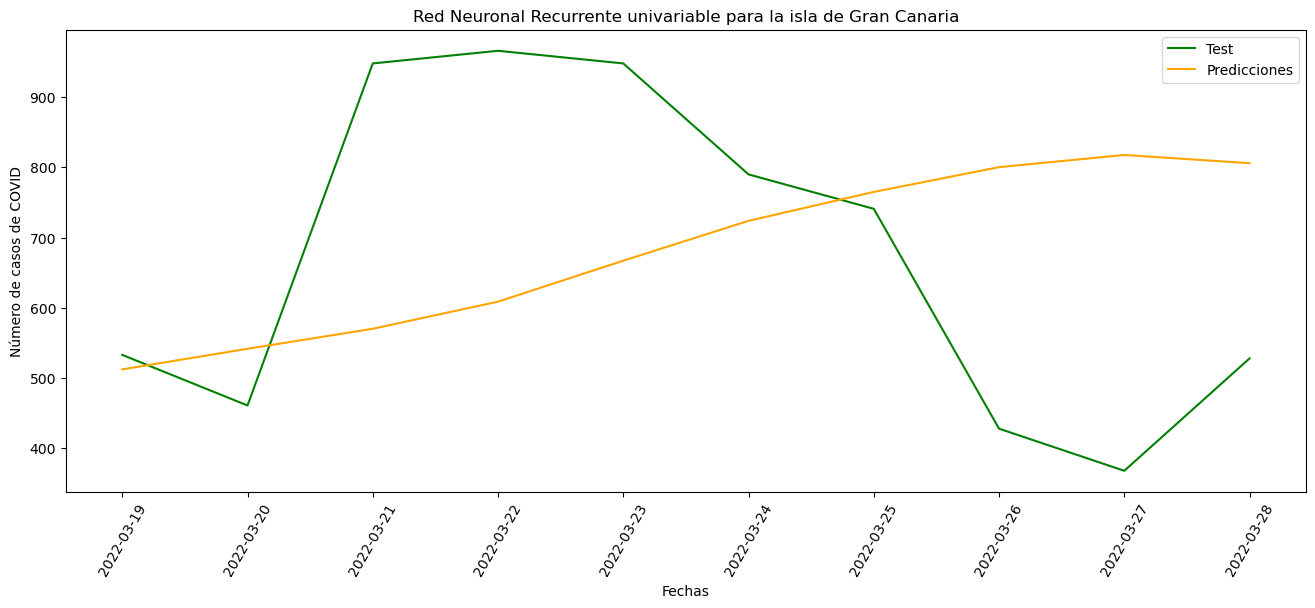

In [13]:
isla = 'Gran Canaria'
fechas = datos_GranCanaria.tail(dias_prediccion).index
tit = 'Red Neuronal Recurrente univariable para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

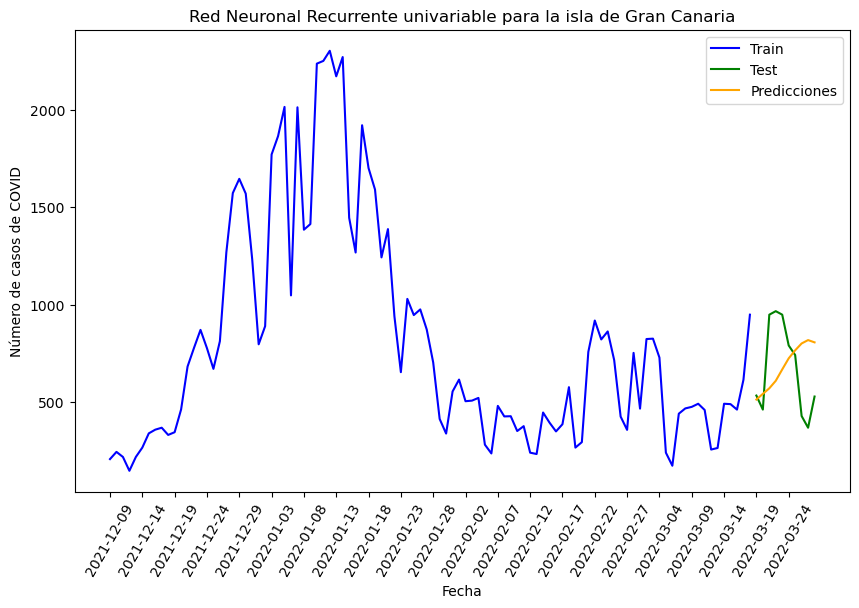

In [14]:
datos_train = datos_GranCanaria_uni.iloc[:n_train]
visualizar_historico(datos_train,y_test,y_pred,'',100,fechas,tit)

In [15]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 77916.51947665811
Error absoluto medio (MAE) del modelo: 230.72567138671874
Raíz del error cuadrático medio (RMSE) del modelo: 279.1353067540151


# Red Neuronal Recurrente multivariable con variables de pandemia

In [16]:
datos_GranCanaria_mult_covid = datos_GranCanaria[[objetivo, 'pcr_total', 'Urg_ingr', 'HPT_cv19', 'CCR_cv19']]
scaler = MinMaxScaler(feature_range=(0, 1))
datos_GranCanaria_mult_covid_scaled = scaler.fit_transform(datos_GranCanaria_mult_covid)

In [17]:
# Escalador para las predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_GranCanaria_mult_covid_scaled_obj = scaler_preds.fit_transform(np.array(datos_GranCanaria_mult_covid[objetivo]).reshape(-1, 1))

In [18]:
n_train = len(datos_GranCanaria_mult_covid_scaled) - dias_prediccion


train = datos_GranCanaria_mult_covid_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_GranCanaria_mult_covid_scaled[n_train - dias_prediccion:len(datos_GranCanaria_mult_covid_scaled), :]

In [19]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [20]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50
7/7 [==============================] - 5s 88ms/step - loss: 0.0375 - val_loss: 0.0606
Epoch 2/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0294 - val_loss: 0.0353
Epoch 3/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0236 - val_loss: 0.0321
Epoch 4/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0166 - val_loss: 0.0379
Epoch 5/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0103 - val_loss: 0.0596
Epoch 6/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0092 - val_loss: 0.0512
Epoch 7/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0075 - val_loss: 0.0401
Epoch 8/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0072 - val_loss: 0.0387
Epoch 9/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0068 - val_loss: 0.0463
Epoch 10/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0066 - val_loss: 0.0397
Epoch 11/50
7/7 [============

In [21]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 301ms/step


In [22]:
y_pred

array([[465.34186],
       [483.76794],
       [554.3396 ],
       [675.7441 ],
       [763.2649 ],
       [817.3314 ],
       [801.834  ],
       [801.8199 ],
       [795.5751 ],
       [803.2269 ]], dtype=float32)

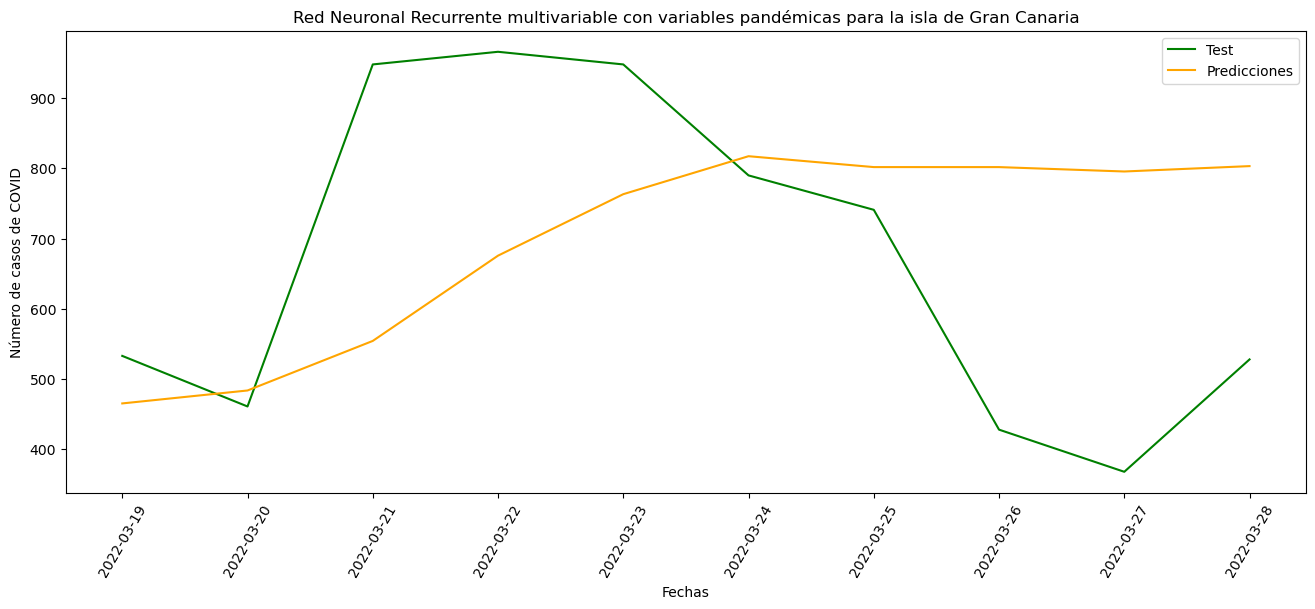

In [23]:
tit = 'Red Neuronal Recurrente multivariable con variables pandémicas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

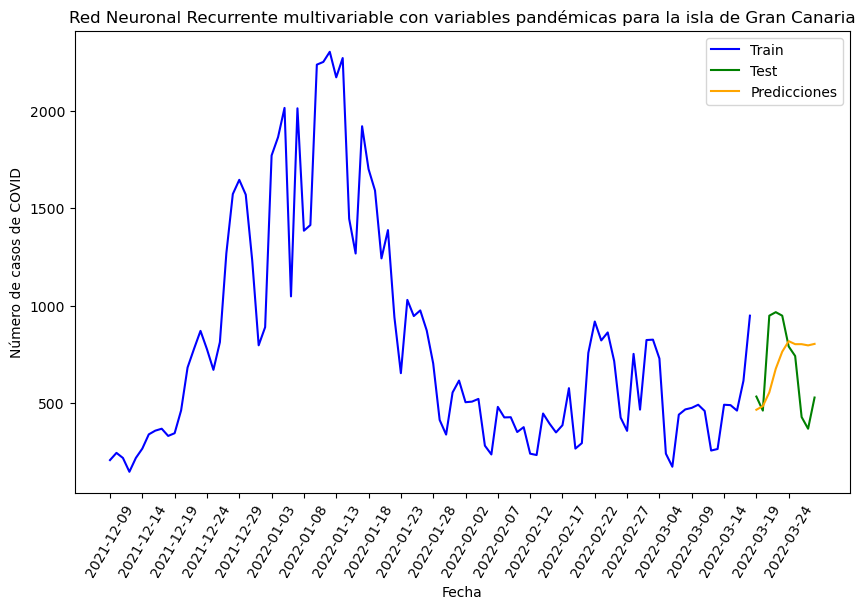

In [24]:
datos_train = datos_GranCanaria_mult_covid.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,100,fechas,tit)

In [25]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 68119.94659435861
Error absoluto medio (MAE) del modelo: 212.38648071289063
Raíz del error cuadrático medio (RMSE) del modelo: 260.9979819737283


# Red Neuronal Recurrente multivariable con variables atmosféricas

In [26]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_GranCanaria_mult_atm_scaled = scaler.fit_transform(datos_GranCanaria_mult_atm)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_GranCanaria_mult_atm_scaled_obj = scaler_preds.fit_transform(np.array(datos_GranCanaria_mult_atm[objetivo]).reshape(-1, 1))

In [27]:
n_train = len(datos_GranCanaria_mult_atm_scaled) - dias_prediccion


train = datos_GranCanaria_mult_atm_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_GranCanaria_mult_atm_scaled[n_train - dias_prediccion:len(datos_GranCanaria_mult_atm_scaled), :]

In [28]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [29]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50
7/7 [==============================] - 4s 81ms/step - loss: 0.0408 - val_loss: 0.0669
Epoch 2/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0326 - val_loss: 0.0398
Epoch 3/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0290 - val_loss: 0.0288
Epoch 4/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0256 - val_loss: 0.0310
Epoch 5/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0198 - val_loss: 0.0210
Epoch 6/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0134 - val_loss: 0.0149
Epoch 7/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0107 - val_loss: 0.0207
Epoch 8/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0093 - val_loss: 0.0149
Epoch 9/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0088 - val_loss: 0.0209
Epoch 10/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0084 - val_loss: 0.0145
Epoch 11/50
7/7 [============

In [30]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 303ms/step


In [31]:
y_pred

array([[ 669.15594],
       [ 668.35345],
       [ 689.91785],
       [ 731.87256],
       [ 735.3813 ],
       [ 727.3346 ],
       [ 906.8005 ],
       [1041.1573 ],
       [1006.11066],
       [ 952.6442 ]], dtype=float32)

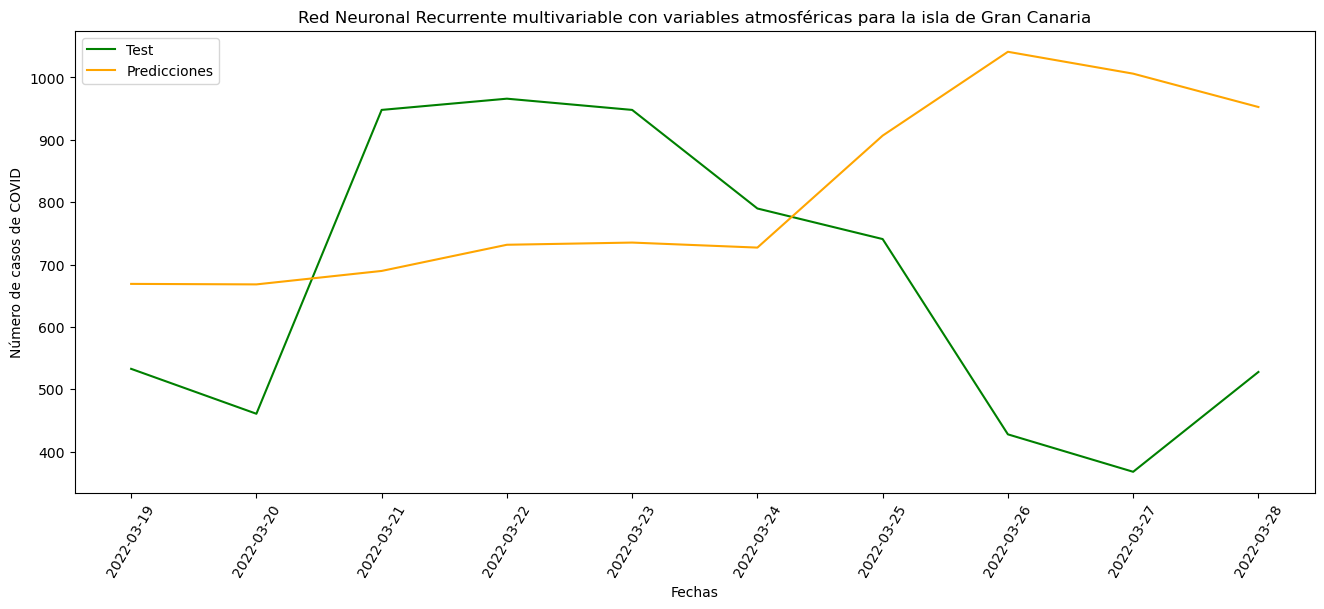

In [32]:
tit = 'Red Neuronal Recurrente multivariable con variables atmosféricas para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

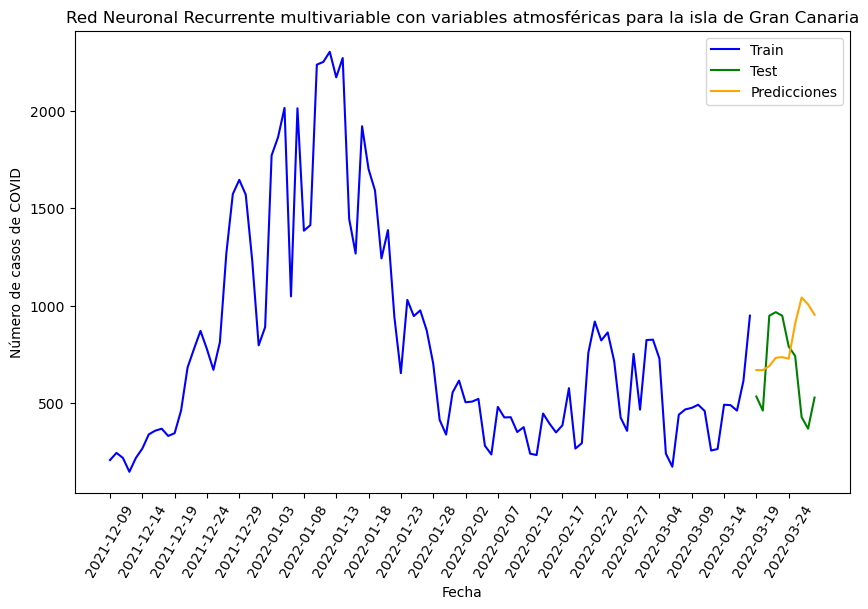

In [33]:
datos_train = datos_GranCanaria_mult_atm.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,100,fechas,tit)

In [34]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 122304.92844501809
Error absoluto medio (MAE) del modelo: 295.27158203125
Raíz del error cuadrático medio (RMSE) del modelo: 349.72121532017195


# Red Neuronal Recurrente multivariable con todas las variables

In [35]:
scaler = MinMaxScaler(feature_range=(0, 1))
datos_GranCanaria_mult_total_scaled = scaler.fit_transform(datos_GranCanaria_mult_total)

# Escalador par alas predicciones y test
scaler_preds = MinMaxScaler(feature_range=(0, 1))
datos_GranCanaria_mult_total_scaled_obj = scaler_preds.fit_transform(np.array(datos_GranCanaria_mult_total[objetivo]).reshape(-1, 1))

In [36]:
n_train = len(datos_GranCanaria_mult_total_scaled) - dias_prediccion


train = datos_GranCanaria_mult_total_scaled[0:n_train, :]

# Para obtener el conjunto de test obtenemos los 10 días anteriores a test para poder conformar el problema supervisado
test = datos_GranCanaria_mult_total_scaled[n_train - dias_prediccion:len(datos_GranCanaria_mult_total_scaled), :]

In [37]:
X_train, y_train = get_X_y(train, dias_prediccion)
X_test, y_test = get_X_y(test, dias_prediccion)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [38]:
modelo = obtener_modelo_red_neuronal(X_train, y_train, X_test, y_test)

Epoch 1/50
7/7 [==============================] - 5s 106ms/step - loss: 0.0390 - val_loss: 0.0561
Epoch 2/50
7/7 [==============================] - 0s 19ms/step - loss: 0.0272 - val_loss: 0.0260
Epoch 3/50
7/7 [==============================] - 0s 19ms/step - loss: 0.0225 - val_loss: 0.0337
Epoch 4/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0137 - val_loss: 0.0375
Epoch 5/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0122 - val_loss: 0.0512
Epoch 6/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0092 - val_loss: 0.0279
Epoch 7/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0082 - val_loss: 0.0434
Epoch 8/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0086 - val_loss: 0.0304
Epoch 9/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0072 - val_loss: 0.0360
Epoch 10/50
7/7 [==============================] - 0s 17ms/step - loss: 0.0065 - val_loss: 0.0321
Epoch 11/50
7/7 [===========

In [39]:
test_pred = modelo.predict(X_test)
y_pred = scaler_preds.inverse_transform(test_pred)
y_test = scaler_preds.inverse_transform(y_test.reshape(-1,1))

1/1 [==============================] - 0s 295ms/step


In [40]:
y_pred

array([[417.50272],
       [413.32645],
       [496.0695 ],
       [684.5121 ],
       [747.7834 ],
       [748.07947],
       [755.5677 ],
       [749.4022 ],
       [739.7946 ],
       [732.6071 ]], dtype=float32)

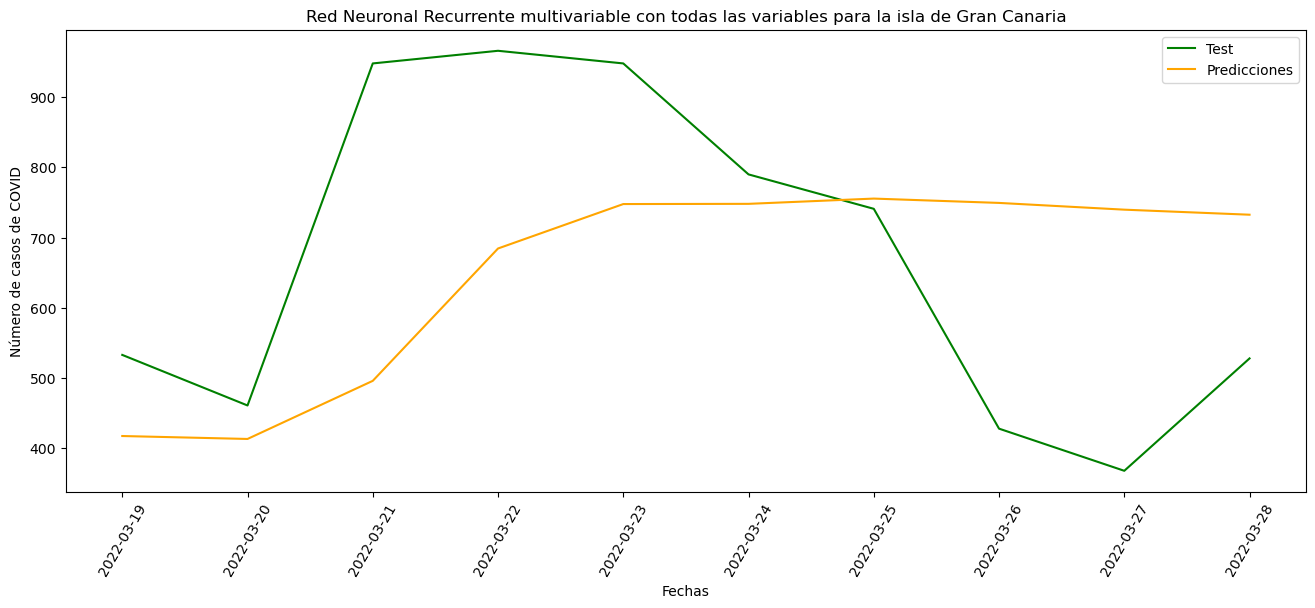

In [41]:
tit = 'Red Neuronal Recurrente multivariable con todas las variables para la isla de ' + isla

visualizar_pred_test(y_test, y_pred, fechas, tit)

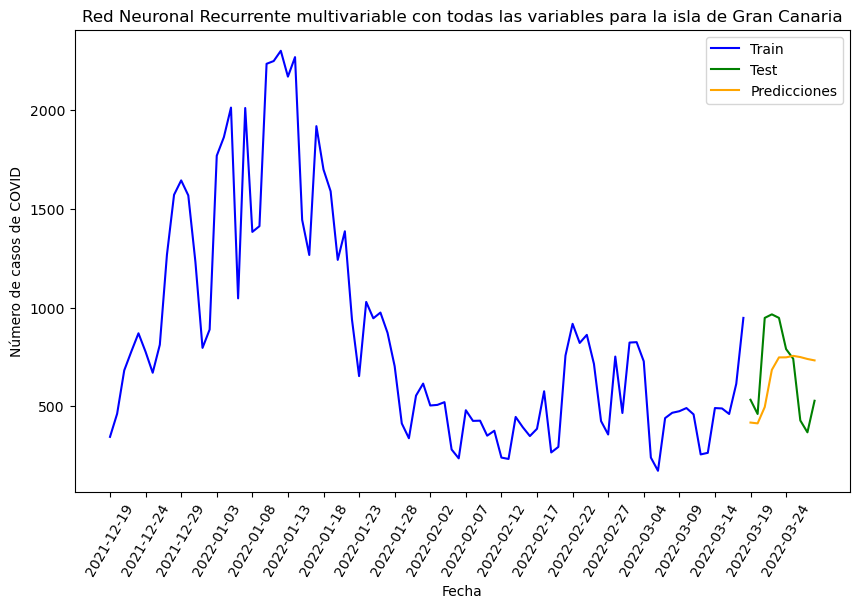

In [42]:
datos_train = datos_GranCanaria_mult_total.iloc[:n_train, :]
visualizar_historico(datos_train,y_test,y_pred,objetivo,90,fechas,tit)

In [43]:
mae, mse, rmse = obtener_errores(y_test, y_pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 62453.99621073259
Error absoluto medio (MAE) del modelo: 205.10980529785155
Raíz del error cuadrático medio (RMSE) del modelo: 249.90797548444226
